In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [46]:
import joblib
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

1. Reading the dataset

In [8]:
path = r'../dataset/gold_data_20_y_cleaned.csv'    
df = pd.read_csv(path, parse_dates=['Date'])
df = df.sort_values("Date")
df = df.reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Date,IR14270,Open,High,Low,Close,Volume,CPIAUCSL,FEDFUNDS,Open sp500,High sp500,Low sp500,Close sp500,Volume sp500,Open usd_index,High usd_index,Low usd_index,Close usd_index
0,2000-08-30,10.4,273.899994,273.899994,273.899994,273.899994,0.0,172.7,6.50,1509.839966,1510.489990,1500.089966,1502.589966,8.184000e+08,112.190002,112.779999,112.110001,112.139999
1,2000-08-31,10.4,274.799988,278.299988,274.799988,278.299988,0.0,172.7,6.50,1502.589966,1525.209961,1502.589966,1517.680054,1.056600e+09,111.980003,112.930000,111.779999,112.599998
2,2000-09-01,10.2,277.000000,277.000000,277.000000,277.000000,0.0,173.6,6.52,1517.680054,1530.089966,1515.530029,1520.770020,7.677000e+08,112.360001,112.599998,111.250000,111.419998
3,2000-09-05,10.2,275.799988,275.799988,275.799988,275.799988,2.0,173.6,6.52,1520.770020,1520.770020,1504.209961,1507.079956,8.385000e+08,111.610001,112.769997,111.500000,112.410004
4,2000-09-06,10.2,274.200012,274.200012,274.200012,274.200012,0.0,173.6,6.52,1507.079956,1512.609985,1492.119995,1492.250000,9.951000e+08,112.449997,114.239998,112.320000,114.120003


2. Preprocessing the dataset

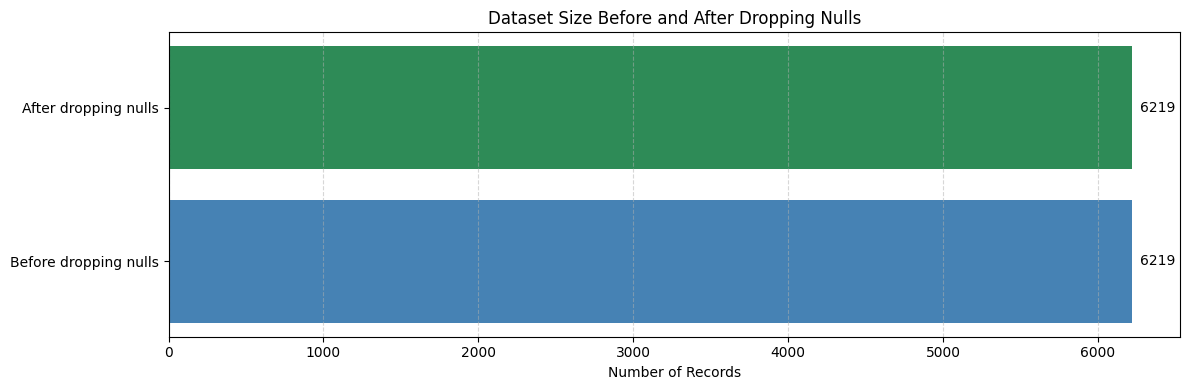

In [17]:
before = len(df)
df = df.dropna()
after = len(df)

labels = ['Before dropping nulls', 'After dropping nulls']
values = [before, after]

plt.figure(figsize=(12, 4))
plt.barh(labels, values, color=['steelblue', 'seagreen'])

for index, value in enumerate(values):
    plt.text(value + 50, index, str(value), va='center')

plt.title('Dataset Size Before and After Dropping Nulls')
plt.xlabel('Number of Records')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

Dataset was already cleaned from null values.

3. Feature engineering

In [19]:
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month

df["day_sin"] = np.sin(2 * np.pi * df["day"] / 31)
df["day_cos"] = np.cos(2 * np.pi * df["day"] / 31)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

In [20]:
def create_lags(df, column, lags=[1,3,7]):
    for lag in lags:
        df[f'{column}_lag{lag}'] = df[column].shift(lag)

In [21]:
cols_to_lag = [
    'Close', 'Close sp500', 'Close usd_index', 'CPIAUCSL'
]

for col in cols_to_lag:
    create_lags(df, col)

df = df.dropna()
df.head()

,Date,IR14270,Open,High,Low,Close,Volume,CPIAUCSL,FEDFUNDS,Open sp500,...,Close_lag7,Close sp500_lag1,Close sp500_lag3,Close sp500_lag7,Close usd_index_lag1,Close usd_index_lag3,Close usd_index_lag7,CPIAUCSL_lag1,CPIAUCSL_lag3,CPIAUCSL_lag7
7,2000-09-11,10.2,273.100006,273.100006,273.100006,273.100006,0.0,173.6,6.52,1494.500000,...,273.899994,1494.500000,1492.25000,1502.589966,114.339996,114.120003,112.139999,173.6,173.6,172.7
8,2000-09-12,10.2,272.899994,272.899994,272.899994,272.899994,0.0,173.6,6.52,1489.260010,...,278.299988,1489.260010,1502.51001,1517.680054,115.370003,113.650002,112.599998,173.6,173.6,172.7
9,2000-09-13,10.2,272.799988,272.799988,272.799988,272.799988,0.0,173.6,6.52,1481.989990,...,277.000000,1481.989990,1494.50000,1520.770020,115.169998,114.339996,111.419998,173.6,173.6,173.6
10,2000-09-14,10.2,272.399994,272.399994,272.399994,272.399994,0.0,173.6,6.52,1484.910034,...,275.799988,1484.910034,1489.26001,1507.079956,115.339996,115.370003,112.410004,173.6,173.6,173.6
11,2000-09-15,10.2,272.299988,272.299988,272.299988,272.299988,0.0,173.6,6.52,1480.869995,...,274.200012,1480.869995,1481.98999,1492.250000,115.160004,115.169998,114.120003,173.6,173.6,173.6


In [22]:
df.columns

Index(['Date', 'IR14270', 'Open', 'High', 'Low', 'Close', 'Volume', 'CPIAUCSL',
       'FEDFUNDS', 'Open sp500', 'High sp500', 'Low sp500', 'Close sp500',
       'Volume sp500', 'Open usd_index', 'High usd_index', 'Low usd_index',
       'Close usd_index', 'day', 'month', 'day_sin', 'day_cos', 'month_sin',
       'month_cos', 'Close_lag1', 'Close_lag3', 'Close_lag7',
       'Close sp500_lag1', 'Close sp500_lag3', 'Close sp500_lag7',
       'Close usd_index_lag1', 'Close usd_index_lag3', 'Close usd_index_lag7',
       'CPIAUCSL_lag1', 'CPIAUCSL_lag3', 'CPIAUCSL_lag7'],
      dtype='object')

In [23]:
def add_rolling_features(df, col, windows=[3,7]):
    for w in windows:
        df[f"{col}_roll_mean{w}"] = df[col].rolling(w).mean()
        df[f"{col}_roll_std{w}"] = df[col].rolling(w).std()

In [24]:
for col in cols_to_lag:
    add_rolling_features(df, col)

df = df.dropna()

print(f'Length of the dataset is: {len(df)}')

df.head()

Length of the dataset is: 6206


,Date,IR14270,Open,High,Low,Close,Volume,CPIAUCSL,FEDFUNDS,Open sp500,...,Close sp500_roll_mean7,Close sp500_roll_std7,Close usd_index_roll_mean3,Close usd_index_roll_std3,Close usd_index_roll_mean7,Close usd_index_roll_std7,CPIAUCSL_roll_mean3,CPIAUCSL_roll_std3,CPIAUCSL_roll_mean7,CPIAUCSL_roll_std7
13,2000-09-19,10.2,271.899994,271.899994,271.899994,271.899994,0.0,173.6,6.52,1444.510010,...,1472.464303,16.237657,116.016668,0.086216,115.584286,0.414924,173.6,0.0,173.6,0.0
14,2000-09-20,10.2,269.000000,269.000000,269.000000,269.000000,0.0,173.6,6.52,1459.900024,...,1467.047154,16.024420,116.173335,0.212213,115.732858,0.502386,173.6,0.0,173.6,0.0
15,2000-09-21,10.2,270.299988,270.299988,270.299988,270.299988,0.0,173.6,6.52,1451.339966,...,1462.341448,15.738986,115.930000,0.590935,115.747143,0.484828,173.6,0.0,173.6,0.0
16,2000-09-22,10.2,271.799988,271.799988,271.799988,271.799988,0.0,173.6,6.52,1449.050049,...,1457.171439,12.750128,115.079999,1.434471,115.492858,0.963981,173.6,0.0,173.6,0.0
17,2000-09-25,10.2,274.100006,274.100006,274.100006,274.100006,0.0,173.6,6.52,1448.719971,...,1451.194301,9.062750,114.296664,0.879223,115.335714,1.106421,173.6,0.0,173.6,0.0


In [25]:
print(f'Number of features: {len(df.columns)}')

Number of features: 52


4. Scaling the values

In [30]:
target = ['Close']
features = [col for col in df.columns if col not in ['Date', target]]

In [34]:
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [35]:
path = r'../scalers/scaler1.pkl'
joblib.dump(scaler, path)

['../scalers/scaler1.pkl']

In [44]:
df.head()

,Date,IR14270,Open,High,Low,Close,Volume,CPIAUCSL,FEDFUNDS,Open sp500,...,Close sp500_roll_mean7,Close sp500_roll_std7,Close usd_index_roll_mean3,Close usd_index_roll_std3,Close usd_index_roll_mean7,Close usd_index_roll_std7,CPIAUCSL_roll_mean3,CPIAUCSL_roll_std3,CPIAUCSL_roll_mean7,CPIAUCSL_roll_std7
13,2000-09-19,0.00339,0.005303,0.004892,0.005361,0.005290,0.0,0.0,1.0,0.140275,...,0.143524,0.050639,0.913425,0.037809,0.910187,0.148564,0.0,0.0,0.0,0.0
14,2000-09-20,0.00339,0.004393,0.003994,0.004441,0.004376,0.0,0.0,1.0,0.143096,...,0.142523,0.049931,0.916644,0.097027,0.913269,0.184030,0.0,0.0,0.0,0.0
15,2000-09-21,0.00339,0.004801,0.004397,0.004854,0.004786,0.0,0.0,1.0,0.141527,...,0.141653,0.048983,0.911644,0.275025,0.913565,0.176911,0.0,0.0,0.0,0.0
16,2000-09-22,0.00339,0.005271,0.004861,0.005329,0.005258,0.0,0.0,1.0,0.141107,...,0.140697,0.039057,0.894178,0.671483,0.908291,0.371208,0.0,0.0,0.0,0.0
17,2000-09-25,0.00339,0.005993,0.005574,0.006059,0.005982,0.0,0.0,1.0,0.141047,...,0.139593,0.026812,0.878082,0.410519,0.905031,0.428967,0.0,0.0,0.0,0.0


5. Splitting the dataset

In [37]:
X = df[features]
y = df[target]

split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

7. Training XGBoost Model

In [43]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [45]:
xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [47]:
y_pred = xgb.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R² Score: -0.4236
Mean Squared Error: 0.0237


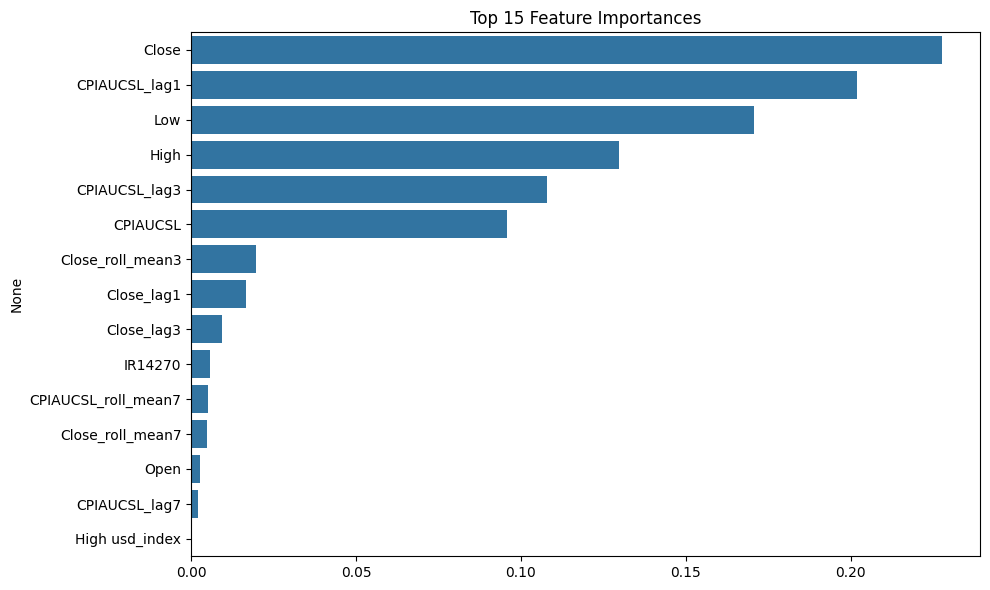

In [48]:
importances = xgb.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:15], y=feat_imp.index[:15])
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

In [49]:
path = r'../models/model1.pkl'
joblib.dump(xgb, path)

['../models/model1.pkl']